In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn import datasets
%run './Plotting Tools.ipynb'
%run './Loading Dataset and Preprocess.ipynb'
RUN_DEMONSTRATION = False

In [2]:
def train_model(train, test, model, criterion, optimizer, nepochs=100, batched=False, device=None):
    # default to CPU device
    if device is None:
        # use GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available()
                              else "cpu")
        
        # move to appropriate device
        model.to(device)
    
    print(f'Training model \n{model}\n on device {device} for {nepochs} epochs.')
    
    %matplotlib notebook
    
    lossplot = LivePlot(2)
    
    if not batched:
        ds_train = (train,)
        ds_test = (test,)
    else:
        ds_train = train
        ds_test = test

    overall_time = 0
    for epoch in range(nepochs + 1):
        
        with Timer('EpochTimer') as et:
            # evaluate test metrics
            loss_test = 0
            test_n = 0
            for X, Y in ds_test:
                X = X.float().to(device)
                Y = Y.long().to(device)
                pred = model(X)
                loss = criterion(pred, Y)

                loss_test += loss.item() * X.shape[0]
                test_n += X.shape[0]

            # train and evaluate train metrics
            loss_train = 0
            train_n = 0
            for X, Y in ds_train:
                X = X.float().to(device)
                Y = Y.long().to(device)
                pred = model(X)

                loss = criterion(pred, Y)

                loss_train += loss.item() * X.shape[0]
                train_n += X.shape[0]

                if epoch != nepochs:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            lossplot.update((loss_train / train_n, loss_test / test_n))
        taken = et.time_taken()
        overall_time += taken
        epochs_left = nepochs - epoch
        time_left = (overall_time / (epoch + 1)) * epochs_left
        print(f'epoch {epoch}, tr{loss_train / train_n:.2f} ts{loss_test / test_n:.2f} t{taken:.2f}s left {time_left / 60:.0f}m {time_left % 60:.0f}s', end='\r')

# Demonstration

Training model 
Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=50, out_features=10, bias=True)
)
 on device cuda:0 for 50 epochs.


<IPython.core.display.Javascript object>


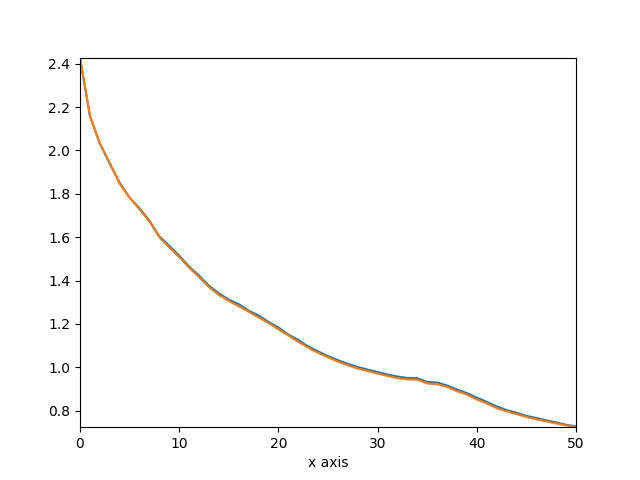

<ipython-input-1-c179ce85a715>:57: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.ax.set_xlim(0, len(s) - 1)


In [3]:
if RUN_DEMONSTRATION:
    import torchvision
    test = torchvision.datasets.MNIST('./tmp/mnist/', train=False, download=True)
    train = torchvision.datasets.MNIST('./tmp/mnist/', train=True, download=True)
    test = (test.data.view(-1, 28*28), test.targets)
    train = (train.data.view(-1, 28*28), train.targets)
    
    model = torch.nn.Sequential(
        torch.nn.Linear(28*28, 50),
        torch.nn.Sigmoid(),
        torch.nn.Linear(50, 10)
    )
    train_model(
        train,
        test,
        model,
        torch.nn.CrossEntropyLoss(),
        torch.optim.SGD(model.parameters(), lr=.1),
        nepochs=50
    )
    